In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from sympy import fibonacci,prime,divisors,factorint
from z3 import *
from scipy.ndimage import measurements
from IPython.display import Markdown, display,Image,HTML

The 11-by-11 grid above is divided into several regions. Place positive digits (1-9) into the cells. Every cell within a region must contain the same digit, and orthogonally adjacent cells in different regions must have different digits. After doing this, place some tiles into the grid. Tiles are represented by blacking out a cell, and no two tiles are allowed to share a common edge. When a tile is placed on a cell, it displaces the value (digit) in that cell. That means the orthogonally adjacent  cells, collectively, must be incremented by that displaced value. (For instance, in the example the rightmost tile displaces a 5. That displaced 5 results in increments of 1 for the cells below and to the left of the tile, and an increment of 3 for the cell above it.) Digits may not be incremented any higher than 9. Incrementing digits may cause neighboring cells from different regions to contain the same value – this is fine. Some cells have been highlighted: these cells may not contain tiles and may not be altered by any of the increments. And finally! Each row has been supplied with a clue.

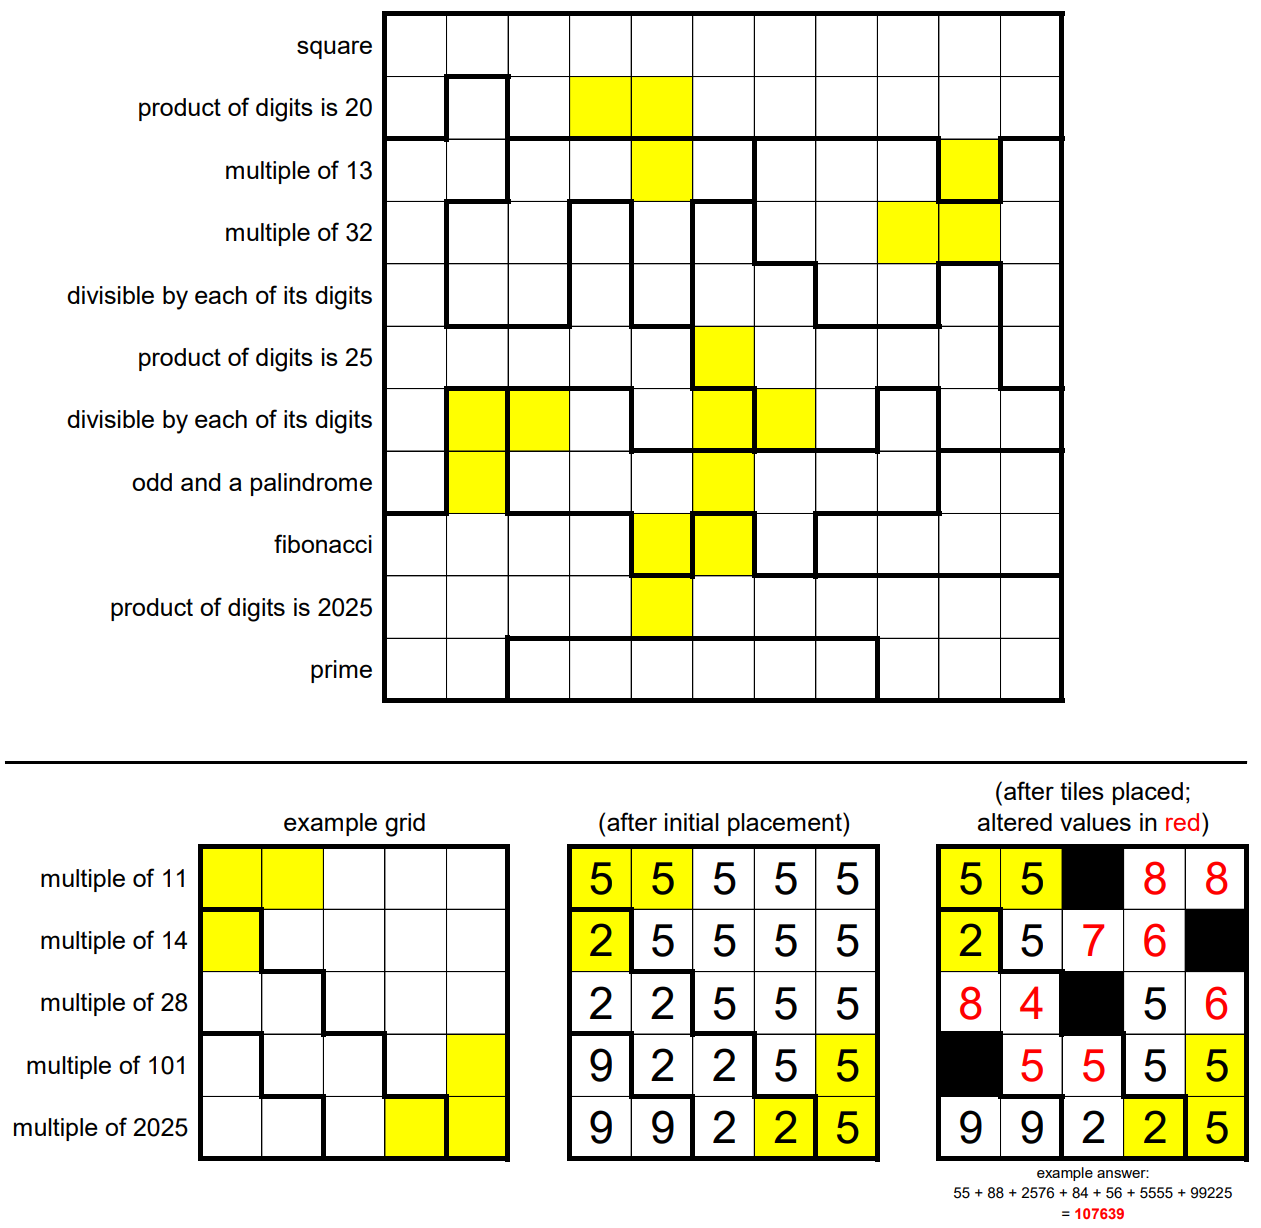

In [2]:
url='https://www.janestreet.com/puzzles/number-cross-5-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[15:23])))
display(Image('https://www.janestreet.com/puzzles/may-2025-update.png',width=600))

In [3]:
def sol_print(regions,matrix,blanks,labels,result):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    x = np.array((matrix).astype('int').astype('str'))
    x[blanks==0] =""
    ax1 =sns.heatmap(regions,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,linecolor='k',annot_kws={"fontsize":14,"color":"k"},alpha=.6,
    yticklabels=labels,ax=ax[0])
    y = np.array((result).astype('int').astype('str'))
    y[result==0] =""
    ax2 =sns.heatmap(regions,annot=y,cbar=False,cmap="tab20",fmt="",linewidths=2,linecolor='k',annot_kws={"fontsize":14,"color":"k"},alpha=.6,ax=ax[1])
    ax1.tick_params(left=False, bottom=False,labelleft=True, labelright=False,labeltop=False,labelbottom=False)
    ax2.tick_params(left=False, bottom=False,labelleft=True, labelright=False,labeltop=False,labelbottom=False)
    
    
    
    plt.yticks(rotation=0,fontsize =10)

    plt.show()

In [4]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def blocks_as_number(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block = block*10+line[n]
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
        
def solve_as_number(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block = int(block*10+line[n])
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block       
        
        
def block_as_sum_digits(split,line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]
                inblock = 1
            else:
                block += line[n]        
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
        
def block_as_prod_digits(split,line):
    block = 1
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block *= line[n]
                inblock = 1
            else:
                block *= line[n]        
        else:
            if inblock == 1:
                yield block
                block = 1
                inblock = 0                    
    if inblock == 1:
        yield block        

        
def blocks_as_block(split,line):
    block = []
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            block += [line[n]]
            inblock = 1
        else:
            if inblock == 1:
                yield block
                block = []
                inblock = 0                    
    if inblock == 1:
        yield block

def valid_shapes(length):
    poss = [[0],[1,1]]
    while len(poss) > 0:
        test = poss.pop()
        if len(test) == length:
            yield(test)
        elif len(test) > length:
            pass
        elif test[-1] == 0:
            poss += [test+[1,1]]
        else:
            poss += [test + [1]]
            poss += [test + [0]]          

In [5]:
def constraint_sq(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([ToInt(n**0.5)==n**0.5 for n in nums]))

def constraint_fib(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == int(fibonacci(i)) for i in range(1,55)]) for n in nums]))

def constraint_prime(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    #return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == int(prime(i)) for i in range(1,1000)]) for n in nums]))
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([Or([n == e for e in [47,887,433]]) for n in nums]))

def constraint_prod(line,ns,split,p):
    nums =[i for i in blocks_as_block(split,ns)]
    if p == 20:
        factors = [{2:2,5:1},{4:1,5:1}]
    elif p == 2025:
        factors = [{3: 4, 5: 2},{3: 2, 5: 2, 9:1},{ 5: 2, 9:2}]
    else:    
        factors = [factorint(p)]
    facts = [{i: ( f[i] if i in f else 0) for i in range(2, 10) } for f in factors]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),
                  And([Or(
                      [And(
                          [And([PbEq([(e==int(k),1) for e in n],v)]) for k,v in f.items()]) for f in facts]) 
                      for n in nums])
                  )

def constraint_mult(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([n % p ==0 for n in nums]))

def constraint_odd(line,ns,split,p):
    nums =[i for i in blocks_as_number(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([n % 2 ==1 for n in nums]))
    

def constraint_div_dig(line,ns,split,p):
    nums = [i for i in blocks_as_number(split,ns)]
    divs = [i for i in blocks_as_block(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([And([And([Implies(n == z, n % z == 0) for z in range(1,10)]) for a in divs[x]])  for x,n in enumerate(nums)] ))

def pal_const(n,p):
    consts = []
    for i in range(0,len(n)//2):
        consts += [n[i] == n[-1-i]]
    return consts

def constraint_pal(line,ns,split,p):
    nums =[i for i in blocks_as_block(split,ns)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([And(pal_const(n,p))  for n in nums]))

In [6]:
def solve(regions,blocked,constraints):
    start = time.time()
    #set up the solver and variables.

    N = regions.shape[1]
    num_regions = len(np.unique(regions))
    print(num_regions)

    s = Tactic("qffd").solver()

    # Y = Base numbers 
    Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
    s += [And(e>0,e<=9) for (i,j),e in np.ndenumerate(Y)]
    
    V = IntVector("v",num_regions) 
    s += [And(e>=0,e<=9) for e in V]

    # B = Tiles
    B = np.array(IntVector("b",N**2),dtype=object).reshape((N,N))
    s += [And(e>=0,e<=1) for (i,j),e in np.ndenumerate(B)]

    # A = addons
    A = np.array(IntVector("a",N**2),dtype=object).reshape((N,N))
    s += [And(e>=0,e<=9) for (i,j),e in np.ndenumerate(A)]

    # X = Final Values
    X = np.array(IntVector("x",N**2),dtype=object).reshape((N,N))
    s += [And(e>=0,e<=9) for (i,j),e in np.ndenumerate(X)]

    
    #Same number in region
    for n,v in enumerate(V):
        s += [e == v for (i,j),e in np.ndenumerate(Y) if regions[i,j] == n]
        
   #tile constraints
    s += [Implies(int(blocked[i,j]) == 1,e !=0) for (i,j),e in np.ndenumerate(B)] # blocked no tile
    s += [Implies(int(blocked[i,j]) == 1,e ==0) for (i,j),e in np.ndenumerate(A)] # blocked not increment
    s += [Implies(B[i,j] == 0,e ==0) for (i,j),e in np.ndenumerate(A)] # blocked not increment
    s += [Implies(e ==0, And([B[k,l] == 1 for k,l in neigh(i,j,N)])) for (i,j),e in np.ndenumerate(B)] #blocked not adjacent
    s += [Implies(B[i,j] == 0 ,e ==0) for (i,j),e in np.ndenumerate(X)]
    s += [Implies(B[i,j] == 1 ,e !=0) for (i,j),e in np.ndenumerate(X)]


    #Adjacent in diff regions diff
    for (i,j),e in np.ndenumerate(Y):
        s+= [Implies(int(regions[i,j]) != int(regions[k,l]),Y[i,j] != Y[k,l]) for k,l in neigh(i,j,N)]
   

    for (i,j),e in np.ndenumerate(X):
        s+= X[i,j] == (Y[i,j]+A[i,j])*B[i,j]
    
   
    # row constraints
    for i in range (N):
        s+= [Implies(B[i,j]==0,And(B[i,j+1] == 1,B[i,j+2] == 1)) for j in range(N-2)]
        s+= B[i,1] != 0
        s+= B[i,-2] != 0
        s+= [Implies(B[i,j] ==0 ,X[i,j+1] !=0) for j in range(N-1)]
        

    #edges
    edge ={}

    for i in range(N):
        for j in range(N):  
            for (k,l) in neigh(i,j,N):
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s+=And(edge[(i,j,k,l)]>=0,edge[(i,j,k,l)] <=9)
    
    
    for i in range(N):
        for j in range(N):       
            x = X[i,j]-Y[i,j]
            s += Implies(x < 0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == Y[i,j])
            s += Implies(x > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == A[i,j])
            s += Implies(x== 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
            s += Implies(x== 0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
            for (k,l) in neigh(i,j,N):
                s += edge[(i,j,k,l)] == edge[(k,l,i,j)]

    s+= Sum([i for  _,i in np.ndenumerate(X-Y)]) ==0

    if N == 11:
        soln = np.array([[0, 3, 4, 2, 2, 2, 5, 0, 3, 2, 4],
                           [5, 4, 0, 2, 2, 5, 0, 2, 5, 2, 0],
                           [0, 5, 3, 4, 3, 0, 6, 5, 0, 2, 6],
                           [7, 3, 6, 0, 3, 2, 0, 5, 4, 4, 0],
                           [0, 5, 5, 5, 0, 2, 2, 0, 8, 1, 6],
                           [5, 5, 0, 5, 5, 1, 0, 1, 5, 5, 0],
                           [0, 3, 6, 7, 4, 4, 1, 2, 0, 1, 5],
                           [7, 3, 7, 0, 9, 6, 9, 0, 9, 9, 0],
                           [3, 4, 0, 4, 6, 3, 6, 8, 0, 8, 9],
                           [5, 3, 5, 9, 3, 0, 5, 9, 9, 5, 0],
                           [0, 4, 7, 0, 8, 8, 7, 0, 4, 3, 3]])
        s+= [X[i,j] ==int(e) for (i,j),e in np.ndenumerate(soln[:,:])] 
        
        assign = np.array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                               [2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2],
                               [4, 4, 3, 3, 3, 3, 4, 4, 4, 2, 4],
                               [4, 3, 3, 4, 3, 1, 4, 4, 4, 4, 4],
                               [4, 3, 3, 4, 3, 1, 1, 4, 4, 1, 4],
                               [4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 4],
                               [4, 3, 6, 6, 4, 4, 1, 1, 6, 1, 1],
                               [4, 3, 6, 6, 6, 6, 6, 6, 6, 7, 7],
                               [3, 3, 3, 3, 6, 3, 6, 7, 7, 7, 7],
                               [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
                               [3, 3, 7, 7, 7, 7, 7, 7, 3, 3, 3]])

        s+= [Y[i,j] ==int(e) for (i,j),e in np.ndenumerate(assign[:,:])] 


    #constraints
    for i,(constraint,param) in enumerate(constraints):
        print(i,constraint,param)

        if constraint == 'fib':
            for shape in valid_shapes(N):
                    s +=constraint_fib(B[i,:],X[i,:],shape,param)

        if constraint == 'mult':
            for shape in valid_shapes(N):            
                    s +=constraint_mult(B[i,:],X[i,:],shape,param)

        if constraint == 'pal':
            for shape in valid_shapes(N):
                    s += constraint_pal(B[i,:],X[i,:],shape,param)
                    s += constraint_odd(B[i,:],X[i,:],shape,param)
                
        if constraint == 'prod':
            for shape in valid_shapes(N):
                    s += constraint_prod(B[i,:],X[i,:],shape,param)   

        if constraint == 'sq':
            for shape in valid_shapes(N):
                    s += constraint_sq(B[i,:],X[i,:],shape,0)

        if constraint == 'div_dig':
            for shape in valid_shapes(N):
                    s += constraint_div_dig(B[i,:],X[i,:],shape,0)

        if constraint == 'prime':
            for shape in valid_shapes(N):
                    s += constraint_prime(B[i,:],X[i,:],shape,0)

    print("setup done in {:.2f} seconds".format(time.time()-start))       
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result_b =  np.array(evalu(B),dtype=int)
        result_x =  np.array(evalu(X),dtype=int)
        result_y =  np.array(evalu(Y),dtype=int)
        result_a =  np.array(evalu(A),dtype=int)
        sol_print(regions,result_x,result_b,labels,result_x-result_y)
        print("Took {:.4f} seconds".format(time.time()- start))
        soln = result_x
        print("solution is {:,.0f}".format(sum([sum([i for i in solve_as_number(result_b[n,:],result_x[n,:])]) for n in range(N)])))
        print([[i for i in solve_as_number(result_b[n,:],result_x[n,:])] for n in range(N)])
        # print([(k,evalu(v)) for k,v in edge.items() if evalu(v) !=0])
        # display(result_x,result_b,result_y,result_a)


    else:
        
        print('fail')

3
0 mult 11
1 mult 14
2 mult 28
3 mult 101
4 mult 2025
setup done in 0.16 seconds


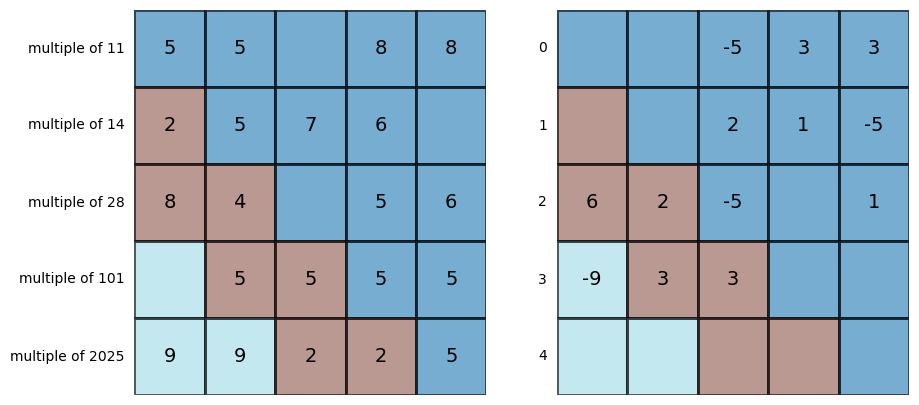

Took 1.5026 seconds
solution is 107,639
[[55, 88], [2576], [84, 56], [5555], [99225]]


In [7]:
regions = np.array(   [[0, 0, 0, 0, 0],
                       [1, 0, 0, 0, 0],
                       [1, 1, 0, 0, 0],
                       [2, 1, 1, 0, 0],
                       [2, 2, 1, 1, 0]])

blocked = np.array(   [[1, 1, 0, 0, 0],
                       [1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1],
                       [0, 0, 0, 1, 1]])

labels =['multiple of 11','multiple of 14','multiple of 28','multiple of 101','multiple of 2025']

constraints = [('mult',11),('mult',14),('mult',28),('mult',101),('mult',2025)]

solve(regions,blocked,constraints)

9
0 sq 1
1 prod 20
2 mult 13
3 mult 32
4 div_dig 1
5 prod 25
6 div_dig 1
7 pal 1
8 fib 1
9 prod 2025
10 prime 1
setup done in 4.85 seconds


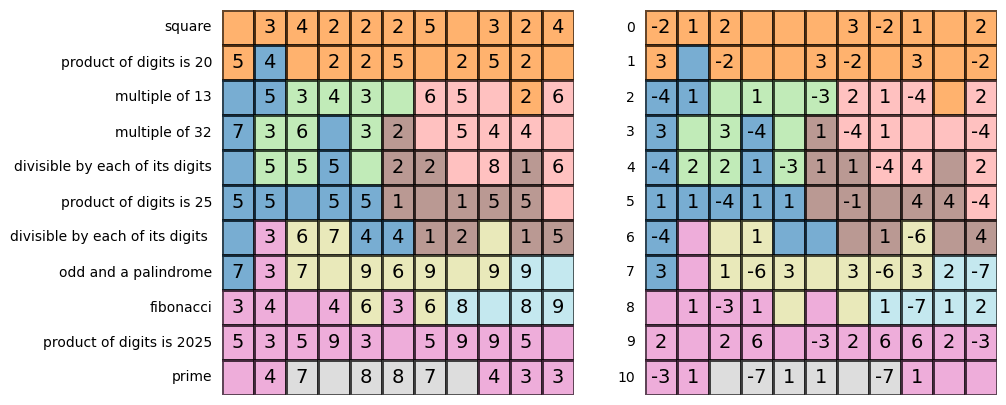

Took 6.0905 seconds
solution is 4,135,658
[[342225, 324], [54, 225, 252], [5343, 65, 26], [736, 32, 544], [555, 22, 816], [55, 551, 155], [3674412, 15], [737, 969, 99], [34, 46368, 89], [53593, 5995], [47, 887, 433]]


In [8]:
regions =   np.array([ [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                       [0, 0, 2, 2, 2, 2, 3, 3, 3, 1, 3],
                       [0, 2, 2, 0, 2, 4, 3, 3, 3, 3, 3],
                       [0, 2, 2, 0, 2, 4, 4, 3, 3, 4, 3],
                       [0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 3],
                       [0, 5, 7, 7, 0, 0, 4, 4, 7, 4, 4],
                       [0, 5, 7, 7, 7, 7, 7, 7, 7, 8, 8],
                       [5, 5, 5, 5, 7, 5, 7, 8, 8, 8, 8],
                       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
                       [5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5]
                      ])

blocked =     np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
                       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
                       [0, 1 ,0, 0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


labels =['square','product of digits is 20','multiple of 13','multiple of 32','divisible by each of its digits','product of digits is 25','divisible by each of its digits ','odd and a palindrome',
         'fibonacci','product of digits is 2025','prime']
constraints = [('sq',1),('prod',20),('mult',13),('mult',32),('div_dig',1),('prod',25),('div_dig',1),('pal',1),('fib',1),('prod',2025),('prime',1)]
solve(regions,blocked,constraints)


In [9]:
labels = ['square','product of digits is 20','multiple of 13','multiple of 32','divisible by each of its digits','product of digits is 25','divisible by each of its digits ','odd and a palindrome',
         'fibonacci','product of digits is 2025','prime']

answers = [[342225, 324], [54, 225, 252], [5343, 65, 26], [736, 32, 544], [555, 22, 816], [55, 551, 155], [3674412, 15], [737, 969, 99], [34, 46368, 89], [53593, 5995], [47, 887, 433]]

[(labels[i],e) for i,e in enumerate(answers)]

[('square', [342225, 324]),
 ('product of digits is 20', [54, 225, 252]),
 ('multiple of 13', [5343, 65, 26]),
 ('multiple of 32', [736, 32, 544]),
 ('divisible by each of its digits', [555, 22, 816]),
 ('product of digits is 25', [55, 551, 155]),
 ('divisible by each of its digits ', [3674412, 15]),
 ('odd and a palindrome', [737, 969, 99]),
 ('fibonacci', [34, 46368, 89]),
 ('product of digits is 2025', [53593, 5995]),
 ('prime', [47, 887, 433])]